# 1. Imports

In [2]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
import requests
import zipfile
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

# 2. Load Train and Validation Datasets

In [9]:
urls = [
    'https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip',
    'https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip'
    ]

zip_files = ['./data/horse-or-human.zip', './data/validation-horse-or-human.zip']

for url, zip_file in zip(urls, zip_files):
    response = requests.get(url)

    with open(zip_file, 'wb') as file:
        file.write(response.content)

    zip_ref = zipfile.ZipFile(zip_file, "r")
    zip_ref.extractall(zip_file.removesuffix(".zip"))
    
    zip_ref.close()

# 3. Inspecting the Dataset

In [10]:
sample_image = load_img("./data/horse-or-human/horses/horse01-0.png")
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (300, 300, 3)


# 4. Training and Validation Generators

In [13]:
def train_val_generators(train_dir, val_dir):

    train_datagen = ImageDataGenerator(rescale=1./255.,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')
    
    train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                        batch_size=32,
                                                        class_mode='binary',
                                                        target_size=(150,150))
    
    val_datagen = ImageDataGenerator(rescale=1./255.)

    val_generator = val_datagen.flow_from_directory(directory=val_dir,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(150,150))
    
    return train_generator, val_generator

In [14]:
train_generator, val_generator = train_val_generators("./data/horse-or-human", "./data/validation-horse-or-human")

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


# 5. Creating a pre-trained model

In [15]:
# Downlading the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-11-13 20:36:26--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.204.91, 142.250.178.27, 216.58.212.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.204.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  27.5MB/s    in 3.4s    

2023-11-13 20:36:30 (24.6 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [16]:
# Importing the InceptionV3 model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [17]:
def create_pre_trained_model(local_weights_file):

    # include_top=False argument is used when loading a pre-trained convolutional neural network (CNN) model 
    # to indicate whether to include the fully connected layers at the top of the network.
    pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                    include_top=False,
                                    weights=None)
    
    pre_trained_model.load_weights(local_weights_file)

    # make all the layers in teh pre-trained model non-trainable
    for layer in pre_trained_model.layers:
        layer.trainable = False

    return pre_trained_model

In [18]:
pre_trained_model = create_pre_trained_model(local_weights_file)

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

# 6. Creating a Callback

In [19]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (logs.get('accuracy')>0.995):
            print("\nReach 99.5% accuracy so cancelling training!")
            self.model.stop_training = True

# 7. Pipelinging the pre-trained model with your own

In [20]:
def output_of_last_layer(pre_trained_model):
    last_desired_layer = pre_trained_model.get_layer('mixed7')
    return last_desired_layer.output

In [21]:
last_output = output_of_last_layer(pre_trained_model)

In [25]:
# The function in teh cell below shows chaining or function composition technique in Python, 
# It's related to how Keras functional API allows you to build complex neural networks
# Look how the type of the pre_trained_model is of a Functional type

# Chaining works like so:
"""
    chained_functions = add_five()(square()(subtract_ten()(3))) 
    
    equivalent to:

    x = subtract_ten()(3)
    x = square()(x)
    x = add_five()(x)
"""

print(type(pre_trained_model))

<class 'keras.src.engine.functional.Functional'>


In [27]:
def create_final_model(pre_trained_model, last_output):
    # Below shows chaining or function composition technique in Python, 
    # It's related to how Keras functional API allows you to build complex neural networks
    x = layers.Flatten()(last_output)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=pre_trained_model.input, outputs=x)
    model.compile(optimizer=RMSprop(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [28]:
model = create_final_model(pre_trained_model, last_output)

In [36]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=50,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/50
33/33 [==============================] - 15s 410ms/step - loss: 0.1609 - accuracy: 0.9494 - val_loss: 0.1115 - val_accuracy: 0.9648
Epoch 2/50
33/33 [==============================] - 13s 394ms/step - loss: 0.0248 - accuracy: 0.9932 - val_loss: 0.0197 - val_accuracy: 0.9961
Epoch 3/50
33/33 [==============================] - 13s 393ms/step - loss: 0.0405 - accuracy: 0.9844 - val_loss: 0.0291 - val_accuracy: 0.9922
Epoch 4/50
33/33 [==============================] - 13s 391ms/step - loss: 0.0331 - accuracy: 0.9893 - val_loss: 0.0444 - val_accuracy: 0.9844
Epoch 5/50
33/33 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9990
Reach 99.5% accuracy so cancelling training!
33/33 [==============================] - 13s 394ms/step - loss: 0.0061 - accuracy: 0.9990 - val_loss: 0.0361 - val_accuracy: 0.9922


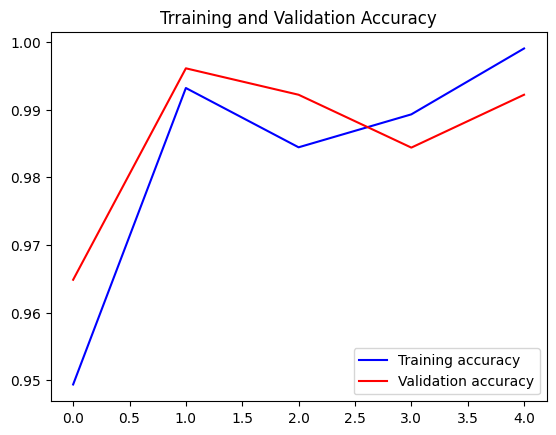

<Figure size 640x480 with 0 Axes>

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label="Training accuracy")
plt.plot(epochs, val_acc, 'r', label="Validation accuracy")
plt.title("Trraining and Validation Accuracy")
plt.legend(loc=0)
plt.figure()

plt.show()